# Volve well logs (composite & petrophysical interp) with Lasio and Welly

Welly is a family of classes to facilitate the loading, processing, and analysis of subsurface wells and well data, such as striplogs, well log curves, and synthetic seismograms.

References:<br>
https://welly.readthedocs.io/en/latest/<br>
https://github.com/agile-geoscience/welly<br>
https://github.com/agile-geoscience/xlines/blob/master/notebooks/08_Read_and_write_LAS.ipynb

In [1]:
import numpy as np
import welly
from welly import Project
from welly import Well
welly.__version__

'0.4.5'

In [2]:
import lasio
lasio.__version__

'0.25.0'

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Begin by following workflow on "Welly to the wescue" (which uses Welly to get data out of LAS files and into so-called feature vectors for a machine learning project, where the features are wireline log measurements). https://agilescientific.com/blog/2016/11/8/welly-to-the-wescue

The benefit of this workflow is that everything is fully reproducible: load the data, apply some tests, fix some problems, and export or process the data. There's no need for intermediate files called things like DT_MATT_EDIT or RHOB_DESPIKE_FINAL_DELETEME. The workflow is completely self-contained.

## Volve composite well logs

In [4]:
# List composite logs

import os

for root, dirs, files in os.walk("./input_data/composite"):
    for filename in files:
        print(filename)

15_9-F-1 A.las
15_9-F-1 B.las
15_9-F-1 C.las
15_9-F-1.las
15_9-F-10.las
15_9-F-11 A.las
15_9-F-11 B.las
15_9-F-11.las
15_9-F-5.las
15_9-F-9 A.las
15_9-F-9.las
_15_9-F-11 T2.las


In [5]:
# Read LAS files into a welly 'project', which contains all the wells. This bit depends on lasio.

p_composite = Project.from_las('input_data\composite\*.las')

0it [00:00, ?it/s]C:\Users\LBHAWZ\AppData\Local\Continuum\anaconda3\lib\site-packages\welly\curve.py:214: UserWarning: Irregular sampling in depth is not supported. Interpolating to regular basis.
  warnings.warn(m)
12it [00:10,  1.16it/s]


Data for Volve exploration wells: 15/9-19 A, B, BT2, S & R (plus 21 dev wells).

Note that most Volve Field composite logs are provided in DLIS format. We have used Interactive Petrophysics software to convert composites for 13 wells to LAS. 

Just two original .LAS are provided in the Volve dataset: 'STAT1990__30-1__15-9-19_SR__COMPOSITE__1.LAS' and 'WLC_PETROPHYSICAL_COMPOSITE - well 15_9-F-7.las'.

In [6]:
# Check what curves we have in our project

p_composite

Index,UWI,Data,Curves
0,15/9-F-1 A,12 curves,"CALI, RDEP, DEN, DENC, ROP, GR, RMED, NEU, PEF, BS, AC, ACS"
1,15/9-F-1 B,12 curves,"CALI, RDEP, DEN, DENC, ROP, GR, RMED, NEU, PEF, BS, AC, ACS"
2,15/9-F-1 C,10 curves,"CALI, RDEP, DEN, DENC, ROP, GR, RMED, NEU, PEF, BS"
3,15/9-F-1,11 curves,"CALI, RDEP, DEN, DENC, ROP, GR, RMED, NEU, PEF, BS, AC"
4,15/9-F-10,12 curves,"CALI, RDEP, DEN, DENC, ROP, GR, RMED, NEU, PEF, BS, AC, ACS"
5,15/9-F-11 A,12 curves,"CALI, RDEP, DEN, DENC, ROP, GR, RMED, NEU, PEF, BS, AC, ACS"
6,15/9-F-11 B,10 curves,"CALI, RDEP, DEN, DENC, ROP, GR, RMED, NEU, PEF, BS"
7,15/9-F-11,5 curves,"RDEP, ROP, GR, RMED, BS"
8,15/9-F-5,11 curves,"CALI, RDEP, DEN, DENC, ROP, GR, RMED, NEU, PEF, BS, AC"
9,15/9-F-9 A,5 curves,"RDEP, ROP, GR, RMED, BS"


Use aliases to simplify things, allowing us to refer to all GR curves as 'Gamma', so for a given well, welly will take the first curve it finds in the list of alternatives we give it. We'll also pass a list of the curves (called keys here) we are interested in.

In [76]:
# Define aliases for curves

alias = {
    'Gamma': ['GR'],
    'Caliper': ['CALI'],
    'Density': ['DEN', 'DENC'],
    'Neutron': ['NEU'],
    'Sonic': ['DT', 'AC', 'ACS'],
    'Resistivity': ['RDEP', 'RMED']
}

# Did not include Drilling logs: 'ROP', 'BS', 'PEF'

In [77]:
keys = ['Gamma', 'Caliper', 'Density', 'Neutron', 'Sonic', 'Resistivity']

In [78]:
p_composite_html = p_composite.curve_table_html(keys=keys, alias=alias)

from IPython.display import HTML
HTML(p_composite_html)

<b>Check curve quality by passing a test suite to the project, and making a quality table.</b>

Define a suite of tests. Lists of test to run on each curve are held in a Python data structure called a dictionary. 

As well as tests for specific curves, there are two special test lists: Each and All, which are run on each curve encountered, and on all curves together, respectively. (The latter is required to, for example, compare the curves to each other to look for duplicates). 

The welly module quality contains some predefined tests, but you can also define your own test functions — these functions take a curve as input, and return either True (for a test pass) for False.

The green dot means that all tests passed for that curve. Orange means some tests failed. If all tests fail, the dot is red. The quality score shows a normalized score for all the tests on that well. In this case, rhob and dt are failing the 'mean_between' test because they have imperial units.

In [81]:
# Check curve quality by passing a test suite to the project, and making a quality table.
# Uses a dictionary of tests:

import welly.quality as qty

tests = {
    'All': [qty.no_similarities],
    'Each': [
        qty.no_flat,
        qty.no_monotonic,
        qty.no_gaps,
    ],
    'Gamma': [
        qty.all_positive,
        qty.all_below(450),
        qty.mean_between(10, 100),
        qty.check_units(['API', 'GAPI']),
    ],
    'Density': [
        qty.mean_between(1000,3000),
        qty.all_positive,
    ],
    'Sonic': [
        qty.mean_between(180, 400),
        qty.all_between(1, 10000),  # 1333 to 5000 m/s
        qty.no_spikes(10),          # 10 spikes allowed
    ],
    }

# Add tests for Caliper, Neutron, Resistivity

p_composite_qty_html = p_composite.curve_table_html(keys=keys, alias=alias, tests=tests)
HTML(p_composite_qty_html)

# Note that you can, for individual wells, return a dictionary of curves in which 
# the values are dictionaries of test name: test result pairs (example in next section)

Fix problems with curves. This part is not yet automated, so it's a fairly hands-on process.

In [11]:
# The data can now be exported as a matrix, specifying a depth step for interpolation.
# All ready for the machine learning task.
    
X, _ = p_composite.data_as_matrix(X_keys=keys, step=0.1, alias=alias)

# produces TypeError: cannot unpack non-iterable NoneType object

15/9-F-1 A 34861
15/9-F-1 B 32681
15/9-F-1 C 38960
15/9-F-1 34351
15/9-F-10 51551
15/9-F-11 A 35737
15/9-F-11 B 45821
15/9-F-11 1583
15/9-F-5 36046
15/9-F-9 A 7906
15/9-F-9 1834
_15/9-F-11 T2 43733


TypeError: cannot unpack non-iterable NoneType object

In [12]:
# We end up with a 2D array of log values

X[:5]

NameError: name 'X' is not defined

### Individual well (15_9-19 SR)

In [14]:
# Original Statoil file: STAT1990__30-1__15-9-19_SR__COMPOSITE__1.LAS
# Export from IP: 15_9-19 SR.las

w_1 = Well.from_las('input_data/composite/STAT1990__30-1__15-9-19_SR__COMPOSITE__1.LAS')
w_2 = Well.from_las('input_data/composite/15_9-19 SR.las')

# It doesn't seem to like loading from sub-directories?

In [15]:
w_1 # Why no SR suffix?

Well(uwi: '', 7 curves: ['AC', 'CALI', 'DEN', 'GR', 'NEU', 'RDEP', 'RMED'])

In [16]:
w_2 

# Note that we lost some header information when exporting from IP
# Lets try using Welly to populate some of these empty header fields like TD, CRS.

Well(uwi: '2105', 7 curves: ['CALI', 'RDEP', 'DEN', 'GR', 'RMED', 'NEU', 'AC'])

In [19]:
print(w_1)
print(w_2)

Well(uwi: '', 7 curves: ['AC', 'CALI', 'DEN', 'GR', 'NEU', 'RDEP', 'RMED'])
Well(uwi: '2105', 7 curves: ['CALI', 'RDEP', 'DEN', 'GR', 'RMED', 'NEU', 'AC'])


In [20]:
w_1.df().head()

,AC,CALI,DEN,GR,NEU,RDEP,RMED
Depth,,,,,,,
102.1568,NaN,NaN,NaN,5.3274,NaN,NaN,NaN
102.3092,NaN,NaN,NaN,5.8235,NaN,NaN,NaN
102.4616,NaN,NaN,NaN,6.5228,NaN,NaN,NaN
102.6140,NaN,NaN,NaN,7.2285,NaN,NaN,NaN
102.7664,NaN,NaN,NaN,9.5020,NaN,NaN,NaN


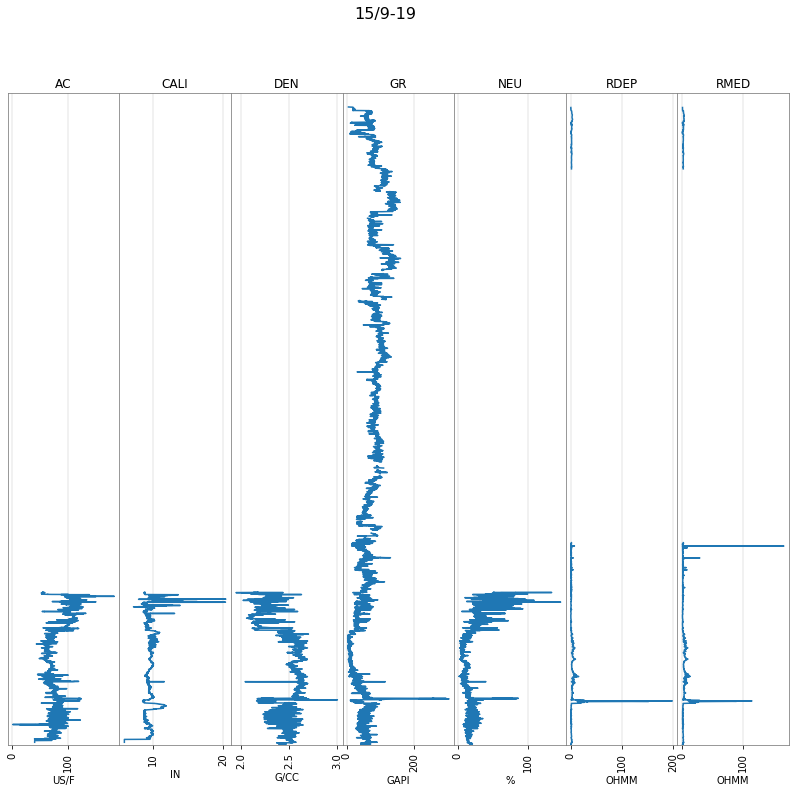

In [21]:
w_1.plot()

In [22]:
gr = w_1.data['GR']
gr

Curve([5.3274, 5.8235, 6.5228, ...,    nan,    nan,    nan])

In [23]:
gr.basis

array([ 102.1568,  102.3092,  102.4616, ..., 4636.2092, 4636.3616,
       4636.514 ])

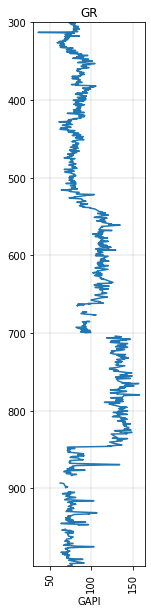

In [24]:
gr.to_basis(start=300, stop=1000).plot()

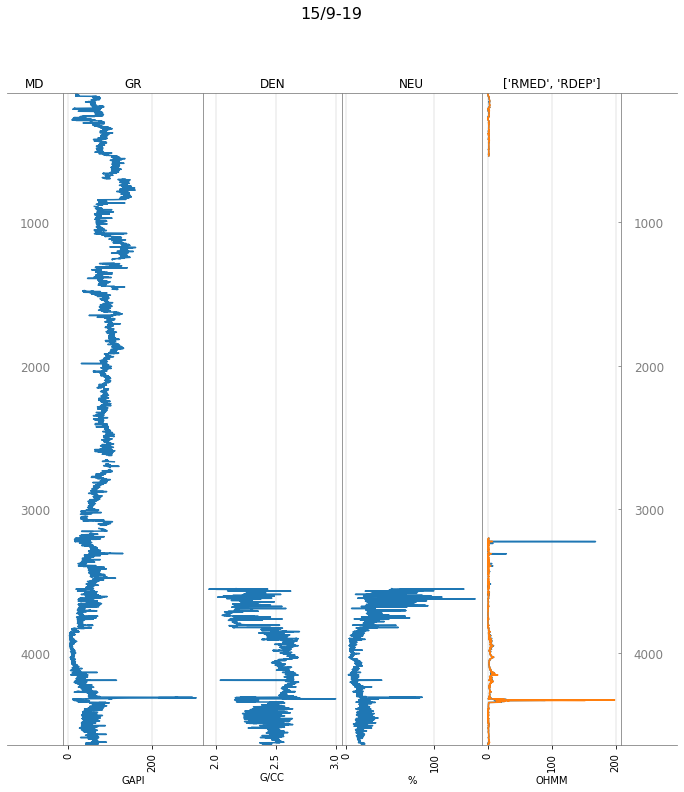

In [74]:
tracks = ['MD', 'GR', 'DEN', 'NEU', ['RMED', 'RDEP'], 'MD']
w_1.plot(tracks=tracks)

# AC, CALI, DEN, GR, NEU, RDEP, RMED

In [83]:
r = w_1.qc_data(tests, alias=alias)
r

# returns a dict of curves (values are dicts of test name: test result pairs)

{'AC': {'no_flat': True,
  'no_monotonic': True,
  'no_gaps': True,
  'mean_between': False,
  'all_between': True,
  'no_spikes': False,
  'no_similarities': True},
 'CALI': {'no_flat': True,
  'no_monotonic': True,
  'no_gaps': True,
  'no_similarities': True},
 'DEN': {'no_flat': True,
  'no_monotonic': True,
  'no_gaps': True,
  'mean_between': False,
  'all_positive': True,
  'no_similarities': True},
 'GR': {'no_flat': True,
  'no_monotonic': True,
  'no_gaps': False,
  'all_positive': True,
  'all_below': True,
  'mean_between': True,
  'check_units': True,
  'no_similarities': True},
 'NEU': {'no_flat': True,
  'no_monotonic': True,
  'no_gaps': True,
  'no_similarities': True},
 'RDEP': {'no_flat': True,
  'no_monotonic': True,
  'no_gaps': False,
  'no_similarities': True},
 'RMED': {'no_flat': True,
  'no_monotonic': True,
  'no_gaps': False,
  'no_similarities': True}}

In [84]:
# And an HTML table for rendering in Notebooks

html = w_1.qc_table_html(tests, alias=alias)
HTML(html)

Curve,Passed,Score,no_flat,all_between,check_units,no_spikes,all_positive,no_similarities,no_monotonic,all_below,mean_between,no_gaps
AC,5 / 7,0.714,True,True,,False,,True,True,,False,True
CALI,4 / 4,1.000,True,,,,,True,True,,,True
DEN,5 / 6,0.833,True,,,,True,True,True,,False,True
GR,7 / 8,0.875,True,,True,,True,True,True,True,True,False
NEU,4 / 4,1.000,True,,,,,True,True,,,True
RDEP,3 / 4,0.750,True,,,,,True,True,,,False
RMED,3 / 4,0.750,True,,,,,True,True,,,False


In [87]:
# Pandas with an alias dictionary
w_1.df(keys=keys, alias=alias, rename_aliased=True)

,Gamma,Caliper,Density,Neutron,Sonic,Resistivity
Depth,,,,,,
102.1568,5.3274,NaN,NaN,NaN,NaN,NaN
102.3092,5.8235,NaN,NaN,NaN,NaN,NaN
102.4616,6.5228,NaN,NaN,NaN,NaN,NaN
102.6140,7.2285,NaN,NaN,NaN,NaN,NaN
102.7664,9.5020,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
4635.9044,NaN,NaN,NaN,NaN,NaN,0.7729
4636.0568,NaN,NaN,NaN,NaN,NaN,0.8369
4636.2092,NaN,NaN,NaN,NaN,NaN,0.8741


In [88]:
# Export curves to data matrix (makes a NumPy array)
w_1.data_as_matrix()

array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       ...,
       [   nan,    nan,    nan, ...,    nan, 0.8741, 0.6888],
       [   nan,    nan,    nan, ...,    nan, 0.9002, 0.8902],
       [   nan,    nan,    nan, ...,    nan, 0.9133, 1.0363]])

In [93]:
# Or similiarly
w_1.df().values

array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       ...,
       [   nan,    nan,    nan, ...,    nan, 0.8741, 0.6888],
       [   nan,    nan,    nan, ...,    nan, 0.9002, 0.8902],
       [   nan,    nan,    nan, ...,    nan, 0.9133, 1.0363]])

In [94]:
# Get depth values separately
w_1.df().index.values

array([ 102.1568,  102.3092,  102.4616, ..., 4636.2092, 4636.3616,
       4636.514 ])

In [90]:
# Export curves to Pandas
df = w_1.df()
df.head()

,AC,CALI,DEN,GR,NEU,RDEP,RMED
Depth,,,,,,,
102.1568,NaN,NaN,NaN,5.3274,NaN,NaN,NaN
102.3092,NaN,NaN,NaN,5.8235,NaN,NaN,NaN
102.4616,NaN,NaN,NaN,6.5228,NaN,NaN,NaN
102.6140,NaN,NaN,NaN,7.2285,NaN,NaN,NaN
102.7664,NaN,NaN,NaN,9.5020,NaN,NaN,NaN


In [97]:
# And to plot the df with UWI column (blank in this instance)
df = w_1.df(uwi=True)
df

AC  CALI  DEN      GR  NEU    RDEP    RMED
UWI Depth                                                
    102.1568  NaN   NaN  NaN  5.3274  NaN     NaN     NaN
    102.3092  NaN   NaN  NaN  5.8235  NaN     NaN     NaN
    102.4616  NaN   NaN  NaN  6.5228  NaN     NaN     NaN
    102.6140  NaN   NaN  NaN  7.2285  NaN     NaN     NaN
    102.7664  NaN   NaN  NaN  9.5020  NaN     NaN     NaN
...            ..   ...  ...     ...  ...     ...     ...
    4635.9044 NaN   NaN  NaN     NaN  NaN  0.7729  0.5978
    4636.0568 NaN   NaN  NaN     NaN  NaN  0.8369  0.6257
    4636.2092 NaN   NaN  NaN     NaN  NaN  0.8741  0.6888
    4636.3616 NaN   NaN  NaN     NaN  NaN  0.9002  0.8902
    4636.5140 NaN   NaN  NaN     NaN  NaN  0.9133  1.0363

[29754 rows x 7 columns]

## Volve - Petrophysical Interpretation logs

In [25]:
# List composite logs

import os

for root, dirs, files in os.walk("./input_data/ppinterp"):
    for filename in files:
        print(filename)

15_9-19_A_CPI.las
15_9-19_BT2_CPI.las
15_9-19_SR_CPI.las
WLC_PETRO_COMPUTED_INPUT_1 - well 15_9-F-11.LAS
WLC_PETRO_COMPUTED_OUTPUT_1 - well 15_9-F-1 A.LAS
WLC_PETRO_COMPUTED_OUTPUT_1 - well 15_9-F-1 B.LAS
WLC_PETRO_COMPUTED_OUTPUT_1 - well 15_9-F-1 C.LAS
WLC_PETRO_COMPUTED_OUTPUT_1 - well 15_9-F-1.LAS
WLC_PETRO_COMPUTED_OUTPUT_1 - well 15_9-F-11 A.LAS
WLC_PETRO_COMPUTED_OUTPUT_1 - well 15_9-F-11 B.LAS
WLC_PETRO_COMPUTED_OUTPUT_1 - well 15_9-F-11 T2.LAS
WLC_PETRO_COMPUTED_OUTPUT_1 - well 15_9-F-12.LAS
WLC_PETRO_COMPUTED_OUTPUT_1 - well 15_9-F-15 D.LAS


In [26]:
# Note that some wells only have ppinterp in DLIS:
# 15_9-F-4
# 15_9-F-5
# 15_9-F-10
# 15_9-F-14
# 15_9-F-15
# 15_9-F-15 A
# 15_9-F-15 B
# 15_9-F-15 C

In [27]:
p_ppinterp = Project.from_las('input_data\ppinterp\*.las')

# Bug? Warning "regex=~P not found" only occurs when files not in main directory

2it [00:00,  3.21it/s]C:\Users\LBHAWZ\AppData\Local\Continuum\anaconda3\lib\site-packages\welly\curve.py:214: UserWarning: Irregular sampling in depth is not supported. Interpolating to regular basis.
  warnings.warn(m)
10it [00:02,  4.71it/s]Header section Parameter regexp=~P was not found.
13it [00:02,  5.15it/s]


In [28]:
p_ppinterp

# No UWIs? Checked .las files, no UWI in all but one. 
# Could add using Lasio (but would have to set one well at a time and re-import. No way to set values with Welly?)

Index,UWI,Data,Curves
0,,23 curves,"BS, BVW, CARB_FLAG, COAL_FLAG, DELTA, GRMAX, GRMIN, J, KLHC_INT, KLOGH, M, N, PERF_FLAG, PHIF, PORD, RHOFL, RHOMA, RW, SAND_FLAG, SW, SWIRR, TEMP, VSH"
1,,13 curves,"BVW, CARB_FLAG, COAL_FLAG, KLOGH, KLOGV, PHIF, RHOFL, RHOMA, RW, SAND_FLAG, SW, TEMP, VSH"
2,,8 curves,"BWV, DT, KLOGH, KLOGV, PHIF, SAND_FLAG, SW, VSH"
3,,10 curves,"BS, GR, RACEHM, RACELM, RD, RM, ROP, RPCEHM, RPCELM, RT"
4,,8 curves,"BVW, COAL_FLAG, KLOGH, PHIF, SAND_FLAG, SW, VCARB, VSH"
5,,9 curves,"BVW, CARB_FLAG, COAL_FLAG, KLOGH, PHIF, SAND_FLAG, SW, VCARB, VSH"
6,,9 curves,"BADDATA_FLAG, BVW, COAL_FLAG, KLOGH, PHIF, SAND_FLAG, SW, VCARB, VSH"
7,,8 curves,"BVW, COAL_FLAG, KLOGH, PHIF, SAND_FLAG, SW, VCARB, VSH"
8,,8 curves,"BVW, CARB_FLAG, COAL_FLAG, KLOGH, PHIF, SAND_FLAG, SW, VSH"
9,,8 curves,"BVW, CARB_FLAG, COAL_FLAG, KLOGH, PHIF, SAND_FLAG, SW, VSH"


In [29]:
alias = {
    'VSH': ['VSH'],
    'SW': ['SW'],
    'BVW': ['BVW'],
    'SAND_FLAG': ['SAND_FLAG'],
    'COAL_FLAG': ['COAL_FLAG'],
    'CARB_FLAG': ['CARB_FLAG'],
    'PHIF': ['PHIF'],
    'KLOGH': ['KLOGH'],
    'BAD DATA': ['BADDATA_FLAG']
}

In [30]:
keys = ['VSH', 'SW', 'BWV', 'PHIF', 'KLOGH', 'BAD DATA', 'SAND_FLAG', 'COAL_FLAG', 'CARB_FLAG']

In [40]:
html = p_ppinterp.curve_table_html(keys=keys, alias=alias)

from IPython.display import HTML
HTML(html)

In [32]:
# Check curve quality by passing a test suite to the project, and making a quality table.
# Example: 'Gamma': [qty.all_positive, qty.mean_between(10, 100),],

tests = {
    'All': [qty.no_similarities],
    'Each': [qty.no_monotonic]
    }

html = p_ppinterp.curve_table_html(keys=keys, alias=alias, tests=tests)
HTML(html)

In [33]:
X, _ = p_ppinterp.data_as_matrix(X_keys=keys, step=0.1, alias=alias)

 4583
 4818
 10687
 

AttributeError: 'NoneType' object has no attribute 'shape'

### PP Interp - Individual well (15/9-19 A)

In [34]:
w15_9_19_A = Well.from_las('input_data/ppinterp/15_9-19_A_CPI.las')
w15_9_19_A

Well(uwi: '', 23 curves: ['BS', 'BVW', 'CARB_FLAG', 'COAL_FLAG', 'DELTA', 'GRMAX', 'GRMIN', 'J', 'KLHC_INT', 'KLOGH', 'M', 'N', 'PERF_FLAG', 'PHIF', 'PORD', 'RHOFL', 'RHOMA', 'RW', 'SAND_FLAG', 'SW', 'SWIRR', 'TEMP', 'VSH'])

In [35]:
w15_9_19_A.df()

,BS,BVW,CARB_FLAG,COAL_FLAG,DELTA,GRMAX,GRMIN,J,KLHC_INT,KLOGH,...,PHIF,PORD,RHOFL,RHOMA,RW,SAND_FLAG,SW,SWIRR,TEMP,VSH
Depth,,,,,,,,,,,,,,,,,,,,,
3666.5916,8.5,0.111705,0.0,0.0,0.1475,115.0,14.0,0.000163,0.0003,0.0003,...,0.199843,0.199843,0.8,2.66,0.021643,0.0,0.5590,1.8023,112.7249,0.598800
3666.7440,8.5,0.112236,0.0,0.0,0.3583,115.0,14.0,0.000003,0.0000,0.0000,...,0.218743,0.218743,0.8,2.66,0.021642,0.0,0.5131,7.9467,112.7285,0.599555
3666.8964,8.5,0.114825,0.0,0.0,0.1298,115.0,14.0,0.000004,0.0000,0.0000,...,0.242380,0.242380,0.8,2.66,0.021642,0.0,0.4737,6.5907,112.7321,0.600310
3667.0488,8.5,0.114419,0.0,0.0,0.2489,115.0,14.0,0.000002,0.0000,0.0000,...,0.226408,0.226408,0.8,2.66,0.021641,0.0,0.5054,8.6274,112.7358,0.601065
3667.2012,8.5,0.115867,0.0,0.0,0.2072,115.0,14.0,0.000004,0.0000,0.0000,...,0.216169,0.216169,0.8,2.66,0.021640,0.0,0.5360,6.8473,112.7394,0.601820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4124.2488,8.5,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.9,NaN,NaN,NaN,NaN,NaN,NaN,0.422817
4124.4012,8.5,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.9,NaN,NaN,NaN,NaN,NaN,NaN,0.422817
4124.5536,8.5,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.9,NaN,NaN,NaN,NaN,NaN,NaN,0.422817


In [65]:
# Make corrections
# Set values and output LAS

las = lasio.read('input_data/ppinterp/15_9-19_A_CPI.las')

# Note that you can't do this with Welly's .Well object, needs to use Lasio 

las.well.UWI = '15/9-19 A'
las.well.CTRY = 'Norway'
las.well.LOC = 'NOR North Sea'
las.well.FLD = 'Volve Field'

print(las.well.UWI.value)
print(las.well.CTRY.value)
print(las.well.LOC.value)
print(las.well.FLD.value)

15/9-19 A
Norway
NOR North Sea
Volve Field


In [66]:
las.well

[HeaderItem(mnemonic=STRT, unit=M, value=3666.5916, descr=START DEPTH),
 HeaderItem(mnemonic=STOP, unit=M, value=4124.8584, descr=STOP DEPTH),
 HeaderItem(mnemonic=STEP, unit=M, value=0.1524, descr=STEP),
 HeaderItem(mnemonic=NULL, unit=, value=-999.25, descr=NULL VALUE),
 HeaderItem(mnemonic=COMP, unit=, value=, descr=COMPANY),
 HeaderItem(mnemonic=WELL, unit=, value=NO_15/9-19_A, descr=WELL),
 HeaderItem(mnemonic=FLD, unit=, value=Volve Field, descr=FIELD),
 HeaderItem(mnemonic=LOC, unit=, value=NOR North Sea, descr=LOCATION),
 HeaderItem(mnemonic=CTRY, unit=, value=Norway, descr=COUNTRY),
 HeaderItem(mnemonic=STAT, unit=, value=, descr=STATE),
 HeaderItem(mnemonic=CNTY, unit=, value=, descr=COUNTY),
 HeaderItem(mnemonic=SRVC, unit=, value=, descr=SERVICE COMPANY),
 HeaderItem(mnemonic=DATE, unit=, value=, descr=DATE),
 HeaderItem(mnemonic=API, unit=, value=, descr=API NUMBER),
 HeaderItem(mnemonic=UWI, unit=, value=15/9-19 A, descr=UNIQUE WELL ID)]

In [68]:
las.write('output_data/w15_9_19_A_corrected.las')

In [69]:
# And now re-import above file with Welly

w15_9_19_A_reimport = Well.from_las('output_data/w15_9_19_A_corrected.las')
w15_9_19_A_reimport

# Not sure where Welly is looking for td and crs (not listed under ~W for any of these LAS files)

Well(uwi: '15/9-19 A', 23 curves: ['BS', 'BVW', 'CARB_FLAG', 'COAL_FLAG', 'DELTA', 'GRMAX', 'GRMIN', 'J', 'KLHC_INT', 'KLOGH', 'M', 'N', 'PERF_FLAG', 'PHIF', 'PORD', 'RHOFL', 'RHOMA', 'RW', 'SAND_FLAG', 'SW', 'SWIRR', 'TEMP', 'VSH'])